<a href="https://colab.research.google.com/github/AlexandreBourrieau/FICHIERS/blob/main/Multi_GAN_HRHN_STOCK_TPU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor

from keras import backend as K

# Initialisation TPU

In [2]:
import os

use_tpu = True

if use_tpu:
    assert 'COLAB_TPU_ADDR' in os.environ, 'Missing TPU; did you request a TPU in Notebook Settings?'

if 'COLAB_TPU_ADDR' in os.environ:
  TPU_ADDRESS = 'grpc://{}'.format(os.environ['COLAB_TPU_ADDR'])
else:
  TPU_ADDRESS = ''

resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu=TPU_ADDRESS)
tf.config.experimental_connect_to_cluster(resolver)
tf.tpu.experimental.initialize_tpu_system(resolver)
print("All devices: ", tf.config.list_logical_devices('TPU'))

INFO:tensorflow:Initializing the TPU system: grpc://10.31.153.234:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.31.153.234:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


All devices:  [LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:7', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:6', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:5', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:4', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:3', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:0', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:1', device_type='TPU'), LogicalDevice(name='/job:worker/replica:0/task:0/device:TPU:2', device_type='TPU')]


# Chargement et correction des données

Le dataset utilisé contient les prix des actions des 81 principales compagnies du NASDAQ100. La valeur de l'index du NASDAQ est utilisé comme cible.  
La fréquence des information est d'une minute, depuis le 26 juillet 2016 jusqu'au 22 décembre 2016, soit 105 jours au total (les samedi et dimanche ne sont pas comptés, ainsi que le 25 novembre qui ne possède que 210 données et le 22 décembre qui n'en possède que 180).

**1. Chargement des données**

In [3]:
!rm *.csv
!curl --location --remote-header-name --remote-name "https://github.com/AlexandreBourrieau/FICHIERS/raw/main/Series_Temporelles/Multi/Data/Stock_complet.csv"

rm: cannot remove '*.csv': No such file or directory
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   180  100   180    0     0    303      0 --:--:-- --:--:-- --:--:--   303
100 1920k  100 1920k    0     0  2671k      0 --:--:-- --:--:-- --:--:-- 2671k


**2. Analyse et correction des données**

In [4]:
# Création de la série sous Pandas
df_etude = pd.read_csv("Stock_complet.csv")
df_etude = df_etude.drop(columns='DateTime')
df_etude = df_etude.astype('float32')
df_etude

,O_AAPL,H_AAPL,L_AAPL,AdjC_AAPL,V_AAPL,C_AMNZ,C_BRENT,C_BSESN,C_CAC40,C_DAX,C_DJI,C_FTSE,C_GOLD,C_GOOG,C_HSI,C_MSFT,C_N225,C_NASDAQ,C_NYSE,C_RUT2000,C_SP500,C_SPTSX,C_SSE,C_USD,C_W5000,C_WTICL,C_AAPL_sma5,C_AAPL_sma7,C_AAPL_sma10,C_AAPL_sma15,C_AAPL_sma21,C_AAPL_macd,C_AAPL_macdh,C_AAPL_macds,C_AAPL_BBl,C_AAPL_BBm,C_AAPL_BBu,C_AAPL_RSI,C_AAPL_FOUR3,C_AAPL_FOUR6,C_AAPL_FOUR9,C_AAPL_LR,C_AAPL_PERCENTLR,C_AAPL
0,9.387143,9.438571,9.296786,8.076332,420375200.0,127.580002,82.199997,18217.439453,3760.719971,6331.330078,10680.429688,5386.200195,1193.699951,252.214645,21549.880859,25.730000,9489.339844,2303.570068,7182.140137,662.960022,1127.239990,11845.099609,2638.521973,80.991997,11827.330078,82.470001,9.327572,9.291939,9.305500,9.280857,9.170510,0.101738,0.000268,0.101469,9.222883,9.327572,9.432260,64.230026,25.862972,22.961653,19.991785,0.062933,0.064955,9.392143
1,9.347500,9.399286,9.305357,8.037019,289097216.0,127.830002,81.610001,18172.830078,3764.189941,6333.580078,10674.980469,5365.799805,1197.199951,253.101318,21551.720703,25.370001,9653.919922,2293.060059,7174.270020,655.070007,1125.810059,11774.799805,2620.757080,80.930000,11797.599609,82.010002,9.348405,9.310255,9.314143,9.298619,9.187943,0.099481,-0.001591,0.101072,9.287694,9.348405,9.409116,60.517967,25.748791,22.791813,19.779182,0.058053,0.059772,9.346429
2,9.277857,9.338929,9.201071,7.987574,444897600.0,128.320007,80.160004,18143.990234,3716.050049,6259.629883,10653.559570,5332.399902,1203.400024,249.176025,21678.800781,25.549999,9642.120117,2288.469971,7153.720215,650.679993,1121.640015,11800.000000,2658.392090,80.496002,11754.440430,80.699997,9.346786,9.324745,9.299892,9.301167,9.205272,0.091992,-0.007264,0.099256,9.280504,9.346786,9.413068,56.124306,25.635012,22.623970,19.571798,0.051882,0.053252,9.288929
3,9.298095,9.346786,9.224166,8.004567,397641056.0,128.490005,80.436668,18191.826172,3736.489990,6290.286621,10668.623047,5358.433105,1202.500000,250.027832,21719.730469,25.570000,9618.910156,2294.209961,7165.246582,653.626648,1123.690063,11821.200195,2663.105469,80.593666,11778.633789,80.959999,9.338167,9.334235,9.298762,9.302841,9.225992,0.086653,-0.010082,0.096735,9.265800,9.338167,9.410535,57.272457,25.521643,22.458143,19.369669,0.054008,0.055493,9.308691
4,9.318333,9.354643,9.247262,8.021561,350384544.0,128.660004,80.713333,18239.664062,3756.930176,6320.943359,10683.686523,5384.466797,1201.599976,250.879639,21760.660156,25.590000,9595.700195,2299.949951,7176.773438,656.573364,1125.739990,11842.399414,2667.818604,80.691338,11802.826172,81.220001,9.332929,9.338725,9.309786,9.306357,9.250102,0.083059,-0.010941,0.094000,9.262320,9.332929,9.403538,58.443516,25.408688,22.294350,19.172829,0.056128,0.057733,9.328452
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3630,96.621666,98.630005,95.073334,94.984985,157851872.0,3136.000000,42.893333,36660.570312,5027.646484,12744.549805,26082.300781,6149.266602,1806.733276,1521.473267,25757.216797,209.270004,22620.097656,10466.373047,12034.973633,1409.939941,3165.159912,15664.200195,3423.297852,96.475998,32263.197266,40.250000,95.682503,95.006783,94.178253,93.016556,92.157974,2.494917,0.133170,2.361747,95.294365,95.682503,96.070633,74.219666,44.328197,45.216000,48.296745,2.383493,9.842714,95.625000
3631,97.264999,99.955002,95.257500,94.838470,191649200.0,3104.000000,42.720001,36693.691406,5056.229980,12799.969727,26085.800781,6176.200195,1811.000000,1511.339966,25772.119141,207.070007,22784.740234,10390.839844,12014.669922,1403.569946,3155.219971,15639.400391,3443.285889,96.406998,32131.820312,40.099998,95.709503,95.294640,94.562378,93.397331,92.432259,2.436403,0.059725,2.376678,95.411385,95.709503,96.007614,73.031967,44.226395,45.003918,48.016922,2.381950,9.825990,95.477501
3632,94.839996,97.254997,93.877502,96.407898,170989200.0,3084.000000,42.900002,36033.058594,5007.459961,12697.360352,26642.

Affiche les types :

In [5]:
df_etude.dtypes

O_AAPL              float32
H_AAPL              float32
L_AAPL              float32
AdjC_AAPL           float32
V_AAPL              float32
C_AMNZ              float32
C_BRENT             float32
C_BSESN             float32
C_CAC40             float32
C_DAX               float32
C_DJI               float32
C_FTSE              float32
C_GOLD              float32
C_GOOG              float32
C_HSI               float32
C_MSFT              float32
C_N225              float32
C_NASDAQ            float32
C_NYSE              float32
C_RUT2000           float32
C_SP500             float32
C_SPTSX             float32
C_SSE               float32
C_USD               float32
C_W5000             float32
C_WTICL             float32
C_AAPL_sma5         float32
C_AAPL_sma7         float32
C_AAPL_sma10        float32
C_AAPL_sma15        float32
C_AAPL_sma21        float32
C_AAPL_macd         float32
C_AAPL_macdh        float32
C_AAPL_macds        float32
C_AAPL_BBl          float32
C_AAPL_BBm          

**5. Affiche les données**

In [6]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Scatter(x=np.linspace(0,len(df_etude),len(df_etude)+1),y=df_etude['C_AAPL'], line=dict(color='blue', width=1),name="Index"))
fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

# Séparation des données de test et d'entrainement

In [7]:
# Sépare les données en entrainement et tests
pourcentage = 0.8
temps_separation = int(len(df_etude.values) * pourcentage)
date_separation = df_etude.index[temps_separation]

serie_entrainement_X = np.array(df_etude.values[:temps_separation],dtype=np.float32)
serie_test_X = np.array(df_etude.values[temps_separation:],dtype=np.float32)

print("Taille de l'entrainement : %d" %len(serie_entrainement_X))
print("Taille de la validation : %d" %len(serie_test_X))

Taille de l'entrainement : 2908
Taille de la validation : 727


**Normalisation des données :**

On normalise les données à l'aide de la fonction [MinMaxScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)

In [8]:
from sklearn import preprocessing

# Constrution des séries
serie_entrainement_X_norm = []
serie_test_X_norm = []

for i in range(0,len(df_etude.columns)):
  serie_entrainement_X_norm.append(serie_entrainement_X[:,i])
  serie_test_X_norm.append(serie_test_X[:,i])

serie_entrainement_X_norm = tf.convert_to_tensor(serie_entrainement_X_norm)
serie_entrainement_X_norm = tf.transpose(serie_entrainement_X_norm)
serie_test_X_norm = tf.convert_to_tensor(serie_test_X_norm)
serie_test_X_norm = tf.transpose(serie_test_X_norm)

# Initialisaton du MinMaxScaler
min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(serie_entrainement_X_norm)

# Normalisation des séries
serie_entrainement_X_norm = min_max_scaler.transform(serie_entrainement_X_norm)
serie_test_X_norm = min_max_scaler.transform(serie_test_X_norm)

In [9]:
print(serie_entrainement_X_norm.shape)
print(serie_test_X_norm.shape)

(2908, 44)
(727, 44)


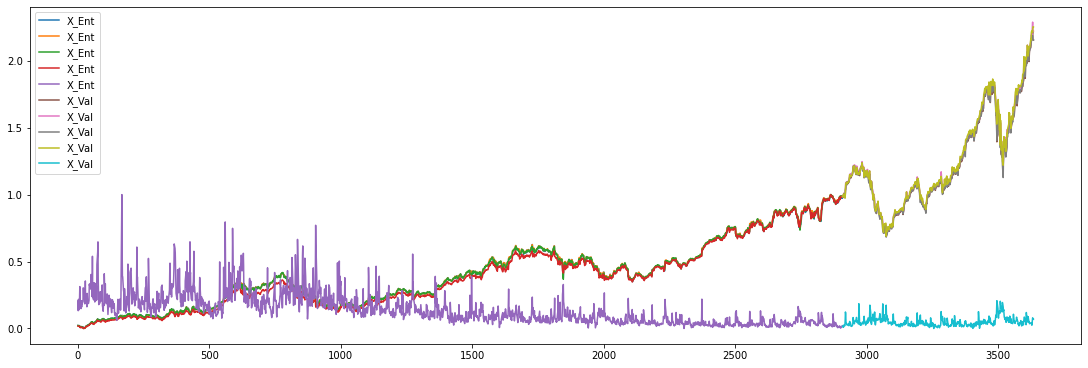

In [10]:
# Affiche quelques séries
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(df_etude.index[:temps_separation].values,serie_entrainement_X_norm[:,0:5], label="X_Ent")
ax.plot(df_etude.index[temps_separation:].values,serie_test_X_norm[:,0:5], label="X_Val")

ax.legend()
plt.show()

# Création des datasets

Les datasets sont créés de la manière suivante :

  <img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ConstructionDataset.png?raw=true' width=500/>

**1. Exemple de dataset**

In [18]:
X1 = np.linspace(1,100,100)
X2 = np.linspace(101,200,100)
X3 = np.linspace(201,300,100)
Y = np.linspace(301,400,100)

X1 = tf.expand_dims(X1,-1)
X2 = tf.expand_dims(X2,-1)
X3 = tf.expand_dims(X3,-1)
Y = tf.expand_dims(Y,-1)

Serie_X = tf.concat([X1,X2,X3],axis=1)
Serie_Y = Y
print(Serie_X.shape)

# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),((X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT-1)}
# Y = YT

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

test_dataset = prepare_dataset_XY(Serie_X,Serie_Y,10,1,1,1)

print(len(list(test_dataset.as_numpy_iterator())))
for element in test_dataset.take(2):
  print(element)

(100, 3)
89
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  1., 101., 201.],
        [  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.]]])>, <tf.Tensor: shape=(1, 10, 1), dtype=float64, numpy=
array([[[301.],
        [302.],
        [303.],
        [304.],
        [305.],
        [306.],
        [307.],
        [308.],
        [309.],
        [310.]]])>), <tf.Tensor: shape=(1, 1, 1), dtype=float64, numpy=array([[[311.]]])>)
((<tf.Tensor: shape=(1, 10, 3), dtype=float64, numpy=
array([[[  2., 102., 202.],
        [  3., 103., 203.],
        [  4., 104., 204.],
        [  5., 105., 205.],
        [  6., 106., 206.],
        [  7., 107., 207.],
        [  8., 108., 208.],
        [  9., 109., 209.],
        [ 10., 110., 210.],
        [ 11., 111., 211.]]])>, <tf.Tensor: shape=(1, 10,

**2. Préparation des datasets**

In [19]:
# Fonction permettant de créer un dataset à partir des données de la série temporelle
# X = {((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),(X3_1,X3_2,...,X3_T)),
#       (Y1,Y2,...,YT)}
# Y = YT+1

def prepare_dataset_XY(seriesX, serieY, longueur_sequence, longueur_sortie, batch_size,shift):
  datasetX = tf.data.Dataset.from_tensor_slices(seriesX)
  datasetX = datasetX.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetX = datasetX.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetX = datasetX.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetX = datasetX.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetY = tf.data.Dataset.from_tensor_slices(serieY)
  datasetY = datasetY.window(longueur_sequence+longueur_sortie, shift=shift, drop_remainder=True)
  datasetY = datasetY.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie))
  datasetY = datasetY.map(lambda x: (x[0:longueur_sequence][:,:]))
  datasetY = datasetY.batch(batch_size,drop_remainder=True).prefetch(1)

  datasetYPred = tf.data.Dataset.from_tensor_slices(serieY)
  datasetYPred = datasetYPred.window(longueur_sequence+longueur_sortie+1, shift=shift, drop_remainder=True)
  datasetYPred = datasetYPred.flat_map(lambda x: x.batch(longueur_sequence + longueur_sortie+1))
  datasetYPred = datasetYPred.map(lambda x: (x[0:-1][-1:,:]))
  datasetYPred = datasetYPred.batch(batch_size,drop_remainder=True).prefetch(1)


  dataset = tf.data.Dataset.zip((datasetX,datasetY))
  dataset = tf.data.Dataset.zip((dataset,datasetYPred))

  return dataset

In [20]:
# Définition des caractéristiques du dataset que l'on souhaite créer
batch_size = 64*8
longueur_sequence = 8
longueur_sortie = 1
shift=1

# Création du dataset
dataset = prepare_dataset_XY(serie_entrainement_X_norm[:,0:-1],serie_entrainement_X_norm[:,-1:], longueur_sequence,longueur_sortie,batch_size,shift)
dataset_val = prepare_dataset_XY(serie_test_X_norm[:,0:-1],serie_test_X_norm[:,-1:],longueur_sequence,longueur_sortie,batch_size,shift)

In [21]:
print(len(list(dataset.as_numpy_iterator())))
for element in dataset.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # (Y1,Y2,...,YT)
  print(element[1].shape)               # YT+1

5
(512, 8, 43)
(512, 8, 1)
(512, 1, 1)


In [22]:
print(len(list(dataset_val.as_numpy_iterator())))
for element in dataset_val.take(1):
  print(element[0][0].shape)            # ((X1),(X2),...) = ((X1_1,X1_2,...,X1_T),(X2_1,X2_2,...,X2_T),...)
  print(element[0][1].shape)            # Y1,Y2,...,YT
  print(element[1].shape)               # YT+1

1
(512, 8, 43)
(512, 8, 1)
(512, 1, 1)


**3. Préparation des X/Y**

In [23]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_train = [X1,X2]
y_train = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_train[0].shape)
print(x_train[1].shape)
print(y_train.shape)


(2560, 8, 43)
(2560, 8, 1)
(2560, 1, 1)


In [24]:
X1 = []
X2 = []

# Extrait les X,Y du dataset
x,y = tuple(zip(*dataset_val))              # x=43x((BS,10,3),(BS,9,1))
                                        # y=43x(BS,1,1)
for i in range(len(x)):
  X1.append(x[i][0])          
  X2.append(x[i][1])

X1 = tf.convert_to_tensor(X1)           # (43,BS,10,3)
X2 = tf.convert_to_tensor(X2)           # (43,BS,9,1)

X1 = np.asarray(X1,dtype=np.float32)    # (43,BS,10,3)
X2 = np.asarray(X2,dtype=np.float32)    # (43,BS,10,3)   

# Recombine les données
y = np.asarray(y,dtype=np.float32)      # 43x(BS,1,1) => (43xBS,1,1)
X1 = np.reshape(X1,(X1.shape[0]*X1.shape[1],X1.shape[2],X1.shape[3]))   # (43,BS,10,3) => (43xBS,10,3)
X2 = np.reshape(X2,(X2.shape[0]*X2.shape[1],X2.shape[2],X2.shape[3]))   # (43,BS,9,1) => (43*BS,9,1)

x_val = [X1,X2]
y_val = np.asarray(tf.reshape(y,shape=(y.shape[0]*y.shape[1],longueur_sortie,y.shape[3])))

# Affiche les formats
print(x_val[0].shape)
print(x_val[1].shape)
print(y_val.shape)


(512, 8, 43)
(512, 8, 1)
(512, 1, 1)


# Affichage des séries

In [ ]:
# Affiche la série
fig, ax = plt.subplots(constrained_layout=True, figsize=(15,5))

ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[0][0,:,0:3],label="X_train (X)")
ax.plot(np.linspace(0,longueur_sequence,longueur_sequence),x_train[1][0,:,:],label="X_train (Y)")

ax.plot(np.linspace(longueur_sequence+1,longueur_sequence+2,1),y_train[0,:,:],label="Y_train",marker="*")

ax.legend()
plt.show()

# Création du modèle HRHN ENC/DEC

Le modèle HRHN est décrit dans ce document de recherche : [Hierarchical Attention-Based Recurrent Highway Networks for Time Series Prediction](https://arxiv.org/pdf/1806.00685)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Mod%C3%A8leHRHN1.png?raw=true' width=700>

**1. Création de l'encodeur**

L'encodeur a pour but de créer des représentations cachées des séries exogènes qui prennent en compte les relations spatiales entre ces séries ainsi que les relations temporelles.  
Les relations spatiales sont extraitent à l'aide d'un ensemble de réseaux de convolution qui produisent des représentations w1, w2... w(T-1).  
Ces représentations sont ensuites codées par un réseau RHN à 3 couches afin d'en extraire les relations temporelles. En sortie de ce réseau RHN, on extrait 3 tenseurs dont chacun contient les (T-1) états cachés de chaque couche du réseau RHN.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

***a. Création des CNN parallèlisés***

La structure d'un réseau de convolution est composée de trois couches CNN-1D + Max-pooling :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN1.png?raw=true'>

L'intégration de caque réseau dans Keras est parallélisée :

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_CNN2.png?raw=true'>

In [25]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]

class Encodeur_CNN(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling,dim_motif):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    super().__init__()                # Appel du __init__() de la classe Layer
  
  # Création de Tin réseaux de convolution + max_pooling en //
  ############################################################
  def build(self,input_shape):
    convs = []
    input_cnns = []

    # Création des Tin entrées des réseaux CNN
    for i in range(input_shape[1]):
        input_cnns.append(tf.keras.Input(shape=(input_shape[2],1)))       # input = Tin*(batch_size,#dim,1)

    # Création des Tin réseaux CNN
    for i in range(input_shape[1]):
      conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[0],      # conv : (batch_size,#dim,16)
                                    kernel_size=self.dim_filtres_cnn[0],
                                    activation='relu',
                                    padding='same',
                                    strides=1)(input_cnns[i])
      conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[0],      # conv : (batch_size,#pooling1,16)
                                       padding='same')(conv)
      for n in range(1,len(self.dim_filtres_cnn)):
        conv = tf.keras.layers.Conv1D(filters=self.nbr_filtres_cnn[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                      kernel_size=self.dim_filtres_cnn[n],
                                      activation='relu',
                                      padding='same',
                                      strides=1)(conv)
        conv = tf.keras.layers.MaxPool1D(pool_size=self.dim_max_pooling[n],    # conv : (batch_size,#pooling_x,dim_filtres_cnn[n])
                                         padding='same')(conv)
      convs.append(conv)
    
    # Création de la sortie concaténée des Tin réseaux CNN
    out = tf.convert_to_tensor(convs)                                     # out : (Tin,batch_size,#pooling,64)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,Tin,#pooling,64)
    out = tf.keras.layers.Reshape(                                        # out : (batch_size,Tin,#pooling*64)
        target_shape=(out.shape[1],out.shape[2]*out.shape[3]))(out)

    if self.dim_motif == 0:
      out = tf.keras.layers.Dense(units=out.shape[2])(out)                  # out : (batch_size,Tin,dim_motif = #pooling*64) 
    else:
      out = tf.keras.layers.Dense(units=self.dim_motif)(out)                # out : (batch_size,Tin,dim_motif) 

    # Création du modèle global
    self.conv_model = tf.keras.Model(inputs=input_cnns,outputs=out)

    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:  Entrée séries exogènes  : (batch_size,Tin,#dim)
  # Sorties :
  #     w:      Sorties des motifs CNN  : (batch_size,Tin,#dim_motif)
  #                                       (taille dernier filtre=64)
  def call(self, input):
    # Coupes temporelles sur les séries exogènes
    # au format : Tin*(batch_size,#dim,1)
    input_list = []
    for i in range(input.shape[1]):
      input_list.append(tf.transpose(input[:,i:i+1,:],perm=[0,2,1]))      # (batch_size,#dim,1)
    # Convolutions spatiales des séries exogènes
    w = self.conv_model(input_list)                                       # (batch_size,Tin,dim_motif)
    return w

***b. Création des cellules RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_RHN.png?raw=true'>

On crée une cellule RHN en reprenant le code précédent auquel :  
- On ajoute la possibilité de retourner tous les états cachés de chaque couche
- On ajoute la prise en compte de la dimension d'entrée correspondant à la dimension des motifs en sortie des réseaux CNN (dim_motif)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Structure_RHN4.png?raw=true'>

In [26]:
class Cellule_RHN(tf.keras.layers.Layer):
  def __init__(self, dim_RHN, nbr_couches, return_all_states = False, dim_input=1):
    self.dim_RHN = dim_RHN
    self.nbr_couches = nbr_couches
    self.dim_input = dim_input
    self.return_all_states = return_all_states
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.Wh = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wh")       # (#dim, #RHN)
    self.Wt = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wt")       # (#dim, #RHN)
    self.Wc = self.add_weight(shape=(input_shape[2],self.dim_RHN),initializer="normal",name="Wc")       # (#dim, #RHN)

    self.Rh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rh")      # (n_couches,#RHN, #RHN)
    self.Rt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rt")      # (n_couches,#RHN, #RHN)
    self.Rc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,self.dim_RHN),initializer="normal",name="Rc")      # (n_couches,#RHN, #RHN)

    self.bh = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bh")        # (n_couches,#RHN, 1)
    self.bt = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bt")        # (n_couches,#RHN, 1)
    self.bc = self.add_weight(shape=(self.nbr_couches,self.dim_RHN,1),initializer="normal",name="bc")        # (n_couches,#RHN, 1)

    super().build(input_shape)        # Appel de la méthode build()

    # Initialisation des masques de dropout
  def InitMasquesDropout(self,drop=0.0):
    self.Wh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Wc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.dim_input,1)),dtype=tf.float32)                 # (#dim,1)
    self.Rh_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rt_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)
    self.Rc_ = tf.convert_to_tensor(np.random.binomial(n=1,p=1.0-drop,size=(self.nbr_couches,self.dim_RHN,1)),dtype=tf.float32)  # (n_couches,#RHN,1)

  # Entrées :
  #     input:          Entrées X[t]        : (batch_size,1,#dim)
  #     init_hidden:    Etat caché Init.    : (batch_size,#RHN)
  # Sorties :
  #     sL:             Etat caché de la dernière couche       : (batch_size,#RHN) 
  #           ou        Etats cachés de chaque couche SL[t]    : (batch_size,nbr_couches,#RHN)
  def call(self, input, init_hidden=None):
    # Construction d'un vecteur d'état nul si besoin
    if init_hidden == None:
      init_hidden = tf.matmul(tf.zeros(shape=(self.dim_RHN,input.shape[2])), # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
                              tf.transpose(input,perm=[0,2,1]))
      init_hidden = tf.squeeze(init_hidden,-1)                               # (batch_size,#RHN,1) => (batch_size,#RHN)
  
    liste_sl = []                                                            # Liste pour  enregistrer les états cachés de chaque couche
    # Calcul de hl, tl et cl
    for i in range(self.nbr_couches):
      if i==0:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[0,:,:],self.Rh[0,:,:])                      # (#RHN,1)_x_(#RHN,#RHN) = (#RHN,#RHN)
        Rt = tf.multiply(self.Rt_[0,:,:],self.Rt[0,:,:])
        Rc = tf.multiply(self.Rc_[0,:,:],self.Rc[0,:,:])

        Wh = tf.multiply(self.Wh_,self.Wh)                                    # (#dim,1)_x_(#dim,#RHN) = (#dim,#RHN)
        Wt = tf.multiply(self.Wt_,self.Wt)
        Wc = tf.multiply(self.Wc_,self.Wc)
   
        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = hl + tf.matmul(tf.transpose(Wh),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tl + tf.matmul(tf.transpose(Wt),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[0,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = cl + tf.matmul(tf.transpose(Wc),
                            tf.transpose(input,perm=[0,2,1]))               # (#RHN,#dim)X(batch_size,#dim,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)

      else:
        # Applique le masque aux poids
        Rh = tf.multiply(self.Rh_[i,:,:],self.Rh[i,:,:])
        Rt = tf.multiply(self.Rt_[i,:,:],self.Rt[i,:,:])
        Rc = tf.multiply(self.Rc_[i,:,:],self.Rc[i,:,:])

        # Calcul de hl
        hl = tf.matmul(Rh,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        hl = hl + self.bh[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        hl = tf.squeeze(hl,-1)                                              # (batch_size,#RHN)
        hl = K.tanh(hl)

        # Calcul de tl
        tl = tf.matmul(Rt,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        tl = tl + self.bt[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        tl = tf.squeeze(tl,-1)                                              # (batch_size,#RHN)
        tl = tf.keras.activations.sigmoid(tl)

        # Calcul de cl
        cl = tf.matmul(Rc,tf.expand_dims(init_hidden,-1))                   # (#RHN,#RHN)X(batch_size,#RHN,1) = (batch_size,#RHN,1)
        cl = cl + self.bc[i,:,:]                                            # (batch_size,#RHN,1) + (#RHN,1) = (batch_size,#RHN,1)
        cl = tf.squeeze(cl,-1)                                              # (batch_size,#RHN)
        cl = tf.keras.activations.sigmoid(cl)
      
      # Calcul de sl
      sl = tf.keras.layers.multiply([hl,tl])                                # (batch_size,#RHN)
      sl = sl + tf.keras.layers.multiply([init_hidden,cl])                  # (batch_size,#RHN)
      liste_sl.append(sl)       # Sauvegarde l'état caché de la couche courante
      init_hidden = sl
    if self.return_all_states == False:
      return sl
    else:
      liste_sl = tf.convert_to_tensor(liste_sl)                             # (nbr_couches,batch_size,#RHN)
      liste_sl = tf.transpose(liste_sl,perm=[1,0,2])                        # (batch_size,nbr_couches,#RHN)
      return liste_sl

***c. Création de l'encodeur : Convolutions + RHN***

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_Encodeur_VueEnsemble.png?raw=true'>

In [27]:
# Arguments de la méthode __init__
#   dim_filtres_cnn   :   liste dimension des filtres ex: [3,3,3]
#   nbr_filtres_cnn   :   liste nbr de filtre sur chaque couche ex: [16,32,64]
#   dim_max_pooling   :   liste dimension max pooling après chaque couche ex: [3,3,3]
#   dim_motif         :   dimension du motif en sortie du CNN
#   dim_RHN_enc       :   dimension du vecteur caché RHN
#   nbr_couches_RHN   :   nombre de couches du RHN
#   dropout           :   dropout variationnel pour le RHN ex: [0.1]

class Encodeur(tf.keras.layers.Layer):
  def __init__(self, dim_filtres_cnn, nbr_filtres_cnn, dim_max_pooling, dim_motif,dim_RHN_enc,nbr_couches_RHN, dropout=0.0):
    self.dim_filtres_cnn = dim_filtres_cnn
    self.nbr_filtres_cnn = nbr_filtres_cnn
    self.dim_max_pooling = dim_max_pooling
    self.dim_motif = dim_motif
    self.dim_RHN_enc = dim_RHN_enc
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.encodeur_cnn = Encodeur_CNN(dim_filtres_cnn=self.dim_filtres_cnn,nbr_filtres_cnn=self.nbr_filtres_cnn,dim_max_pooling=self.dim_max_pooling,dim_motif=self.dim_motif)
    self.RHN = Cellule_RHN(dim_RHN=self.dim_RHN_enc,nbr_couches=self.nbr_couches_RHN,return_all_states=True,dim_input=self.dim_motif)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:          Entrées X         : (batch_size,Tin,#dim)
  # Sorties :
  #     hidden_states   Vecteurs cachés   : (batch_size,nbr_couches,Tin,#RHN)
  def call(self, input):
    # Convolutions spatiales des séries exogènes
    w = self.encodeur_cnn(input)      #  (batch_size,Tin,dim_motif)

    # Encodage des motifs CNN avec les cellules RHN
    sequence = []
    hidden = None

    # Initialisation des masques de dropout pour tous les pas de temps
    self.RHN.InitMasquesDropout(self.dropout)

    # Applique la cellule RHN à chaque pas de temps
    for i in range(input.shape[1]):
      hidden = self.RHN(w[:,i:i+1,:],hidden)          # Envoie (batch_size,1,dim_motif)
      sequence.append(hidden)                         # Sauve (batch_size,nbr_couches,#RHN)

      # Le premier état caché du prochain instant
      # est l'état caché de la dernière couche précédente
      hidden = hidden[:,self.nbr_couches_RHN-1,:]       # (batch_size,#RHN)

    # Traite le format des vecteurs cachés de l'encodeur
    sequence = tf.convert_to_tensor(sequence)               # (Tin,batch_size,nbr_couches,#RHN)
    hidden_states = tf.transpose(sequence,perm=[1,2,0,3])   # (batch_size,nbr_couches,Tin,#RHN)  

    return hidden_states

**2. Création du décodeur**

Le décodeur prend en entrée et à chaque pas de temps :  
- Le tenseur en sortie de l'encodeur RHN qui contient l'ensemble des vecteurs cachés des différentes couches : (batch_size,Nbr_couches,Tin,#RHN)
- L'état caché de la dernière couche du décodeur RHN précédent : (batch_size,#RHN)
- La valeur de la série cible à l'instant courant : (batch_size,1,1)

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_VueEnsembleDecodeur2.png?raw=true'>

**a. Création de la couche d'attention hiérarchique**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/HRHN_AttentionHierarchique.png?raw=true'>

On commence par créer la fonction permettant de calculer les scores. Cette fonction sera appelée avec la méthode TimeDistributed de Keras.

In [28]:
class CalculScore(tf.keras.layers.Layer):
  def __init__(self,dim_RHN_dec):
    self.dim_RHN_dec = dim_RHN_dec
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.T = self.add_weight(shape=(input_shape[1],self.dim_RHN_dec),initializer="normal",name="T")   # (#RHN_enc, #RHN_dec)
    self.U = self.add_weight(shape=(input_shape[1],input_shape[1]),initializer="normal",name="U")     # (#RHN_enc, #RHN_enc)
    self.b = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="b")                  # (#RHN_enc, 1)
    self.v = self.add_weight(shape=(input_shape[1],1),initializer="normal",name="v")                  # (#RHN_enc, 1)
    super().build(input_shape)        # Appel de la méthode build()

  #     hid_state:  Etat initial RHN          : (batch_size,#RHN_dec)
  def SetInitState(self,hid_state):
    self.hid_state = hid_state

  def compute_output_shape(self,input_shape):
    return(input_shape[0],1)

  # Entrées :
  #     input:      1 sortie encodeur RHN     : (batch_size,#RHN_enc)
  # Sorties :
  #     score:      score                     : (batch_size,1,1)
  def call(self, input):
    score = tf.matmul(self.U,tf.expand_dims(input,-1))                      # (#RHN_enc,#RHN_enc)x(batch_size,#RHN_enc,1) = (batch_size,#RHN_enc,1)
    score = score + tf.matmul(self.T,tf.expand_dims(self.hid_state,-1))     # (#RHN_enc,#RHN_dec)(batch_size,#RHN_dec,1) = (batch_size,#RHN_enc,1)
    score = score + self.b                                                  # (batch_size,#RHN_enc,1)
    score = K.tanh(score)
    score = tf.matmul(tf.transpose(self.v),score)                           # (1,#RHN_enc)x(batch_size,#RHN_enc,1) = (batch_size,1,1)
    return tf.squeeze(score,-1)                                             # (batch_size,1)

On crée maintenant la couche d'attention hiérarchique :

In [29]:
class AttentionHierarchique(tf.keras.layers.Layer):
  def __init__(self,dim_RHN_dec):
    self.dim_RHN_dec = dim_RHN_dec
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.couche_score = CalculScore(dim_RHN_dec=self.dim_RHN_dec)
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties d'une couche encodeur RHN       : (batch_size,Tin,#RHN_enc)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN_dec)
  # Sorties :
  #     vc:         SousVecteur contexte                    : (batch_size,1,RHN_enc)
  def call(self, input, hid_state):
    # Calcul des scores
    self.couche_score.SetInitState(hid_state)
    scores = tf.keras.layers.TimeDistributed(self.couche_score)(input)        # (batch_size,Tin,#RHN_enc) : Timestep = Tin
                                                                              # (batch_size,#RHN_enc) envoyé Tin fois
                                                                              # (batch_size,Tin,1) retourné
    scores = tf.keras.activations.softmax(scores,axis=1)                      # (batch_size,Tin,1)

    # Applique les scores aux sorties de la couche RHN
    poids = tf.multiply(input,scores)             # (batch_size,Tin,#RHN_enc)_x_(batch_size,Tin,1) = (batch_size,Tin,#RHN_enc)

    # Calcul le sous-vecteur contexte
    vc = K.sum(poids,axis=1)                      # (batch_size,#RHN_enc)
    return tf.expand_dims(vc,1)                   # (batch_size,1,#RHN_enc)

**b. Création du décodeur**

Dans le décodeur, on parallélise autant de couches d'attention que nécessaire afin de créer un modèle d'attention multi-entrées.

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/ParaDecodeur.png?raw=true'>

In [30]:
class Decodeur(tf.keras.layers.Layer):
  def __init__(self,dim_RHN_dec,nbr_couches_RHN,dropout=0.0):
    self.dim_RHN_dec = dim_RHN_dec
    self.nbr_couches_RHN = nbr_couches_RHN
    self.dropout = dropout
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    attentions = []
    inputs_attention = []

    # Création des "nbr_couches" entrées des attentions
    # Chaque entrée est une liste : [input,init_state] = [((batch_size,Tin,#RHN_enc)),((batch_size,#RHN_dec))]
    for i in range(input_shape[1]):
      inputs_attention.append([tf.keras.Input(shape=(input_shape[2],input_shape[3])),          # input = "nbr_couches"*(batch_size,Tin,#RHN_enc)
                                 tf.keras.Input(shape=(self.dim_RHN_dec))])                    # init_state = "nbr_couches"*(batch_size,#RHN_dec)

    # Création des "nbr_couches" couches d'attentions hierarchiques
    for i in range(input_shape[1]):
      att = AttentionHierarchique(dim_RHN_dec=self.dim_RHN_dec)(
          inputs_attention[i][0],                 # inputs_attention[i][0] : (batch_size,Tin,#RHN_enc)
          inputs_attention[i][1])                 # inputs_attention[i][1] : (batch_size,#RHN_dec)
      attentions.append(att)

    # Création de la sortie concaténée des "nbr_couches" couches d'attentions
    out = tf.convert_to_tensor(attentions)                                # out : (nbr_couches,batch_size,1,#RHN_enc)
    out = tf.transpose(out,perm=[1,0,2,3])                                # out : (batch_size,nbr_couches,1,#RHN_enc)

    # Création du modèle global
    self.att_model = tf.keras.Model(inputs=inputs_attention,outputs=out)

    # Création des poids
    self.Wtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.Vtilda = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)

    # Création du décodeur RHN
    self.dec_RHN = Cellule_RHN(dim_RHN=self.dim_RHN_dec,nbr_couches=self.nbr_couches_RHN,return_all_states=False,dim_input=1)
   
    super().build(input_shape)        # Appel de la méthode build()
    
  # Entrées :
  #     input:      Sorties des couches de l'encodeur RHN   : (batch_size,nbr_couches,Tin,#RHN_enc)
  #     hid_state:  Etat initial RHN                        : (batch_size,#RHN_dec)
  #     Y:          Valeur de la série cible                : (batch_size,1)
  #     only_att    Si =True ne calcul que le vecteur ctx   : True/False
  # Sorties :
  #     d:          Vecteur contexte                        : (batch_size,nbr_couches*RHN_enc)
  #     s:          Vecteur caché décodeur RHN              : (batch_size,#RHN_dec)
  def call(self, input, hid_state, Y,only_att):
    # Initialisation de l'état caché à 0 si besoin
    # Construit le tenseur nul au format (batch_size,#RHN)
    if hid_state == None:
      coef = tf.expand_dims(input[:,0,0,0],-1)                          # (batch_size,1)
      coef = tf.expand_dims(coef,-1)                                    # (batch_size,1,1)
      hid_state = tf.matmul(coef,tf.zeros(shape=(1,self.dim_RHN_dec)))  # (batch_size,1,1)X(1,#RHN_dec) = (batch_size,1,#RHN_dec)
      hid_state = tf.squeeze(hid_state,axis=1)                          # (batch_size,#RHN_dec)

    # Construction de l'entrée du modèle
    # nbr_couches*[((batch_size,Tin,#RHN_enc)),((batch_size,#RHN_dec))]
    input_model = []
    for i in range(input.shape[1]):
      input_model.append([input[:,i,:,:],hid_state])    # [((batch_size,Tin,#RHN_enc)),((batch_size,#RHN_dec))]
    
    # Calcul des sous-vecteurs contextes
    # avec le modèle d'attention hiérarchique parallélisé
    d = self.att_model(input_model)                     # d : (batch_size,nbr_couches,1,#RHN_enc)

    # Concaténation des sous-vecteurs contextes
    d = tf.squeeze(d,axis=2)                            # (batch_size,nbr_couches,#RHN_enc)
    d = tf.keras.layers.Flatten()(d)                    # (batch_size,nbr_couches*RHN_enc)

    if only_att == False :
      # Calcul de y_tilda
      ytilda = self.Wtilda(Y)                             # (batch_size,1)
      ytilda = ytilda + self.Vtilda(d)                    # (batch_size,1)

      # Initialisation des masques de dropout pour tous les pas de temps
      self.dec_RHN.InitMasquesDropout(self.dropout)

      # Décodage avec le réseau RHN
      s = self.dec_RHN(tf.expand_dims(ytilda,-1),hid_state)                  # (batch_size,#RHN_dec)
      return d,s
    else:
      return d

**3. Création de la couche HRHN**

<img src='https://github.com/AlexandreBourrieau/FICHIERS/blob/main/Series_Temporelles/Multi/images/Gene_HRHN.png?raw=true'>

In [31]:
class Net_HRHN(tf.keras.layers.Layer):
  def __init__(self,encodeur,decodeur,longueur_sequence, regul=0.0, drop = 0.0):
    self.encodeur = encodeur
    self.decodeur = decodeur
    self.longueur_sequence = longueur_sequence
    self.regul = regul
    self.drop = drop
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    self.W = tf.keras.layers.Dense(units=1,activation=None,use_bias=None)
    self.V = tf.keras.layers.Dense(units=1,activation=None,use_bias=True)
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:          Entrées X           : (batch_size,Tin,#dim)
  #     output_seq:     Sortie séquence Y   : (batch_size,Tin,1)
  # Sorties :
  #     sortie:         Prédiction Y        : (batch_size,1,1)
  def call(self,input,output_seq):
    # Appel de l'encodeur
    # Récupère l'ensemble des états cachés de l'encodeur RHN
    H = self.encodeur(input)                # (batch_size,nbr_couches,Tin,#RHN_enc)

    # Décodage
    hidden_state = None
    for t in range(input.shape[1]):
      vc, hidden_state = self.decodeur(H,hidden_state,output_seq[:,t:t+1,0],only_att = False)
    
    # Couche d'attention finale
    vc = self.decodeur(H,hidden_state,output_seq[:,0,0],only_att=True)    # (batch_size,#RHN_dec)

    # Génération de la prédiction
    sortie = self.W(hidden_state) + self.V(vc)        # (batch_size,1)
    return tf.expand_dims(sortie,-1)                  # (batch_size,1,1)

#Mise en place du générateur

In [32]:
dim_RHN_enc = 16
dim_RHN_dec = 128

nbr_filtres_cnn = [2,128,16]
dim_filtres_cnn = [3,2,4]
dim_max_pooling = [4,3,1]
nbr_couches_RHN_enc = 3
nbr_couches_RHN_dec = 1

dim_motif = Encodeur_CNN(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=0)(x_train[0][0:1,:,:]).shape[2]
drop=0.000

def get_generateur():
  entrees_sequences = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1))

  dim_motif = Encodeur_CNN(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=0)(x_train[0][0:1,:,:]).shape[2]

  encodeur = Encodeur(dim_filtres_cnn=dim_filtres_cnn,nbr_filtres_cnn=nbr_filtres_cnn,dim_max_pooling=dim_max_pooling,dim_motif=dim_motif,dim_RHN_enc=dim_RHN_enc,nbr_couches_RHN=nbr_couches_RHN_enc,dropout=drop)
  decodeur = Decodeur(dim_RHN_dec=dim_RHN_dec,nbr_couches_RHN=nbr_couches_RHN_dec,dropout=drop)

  sortie = Net_HRHN(encodeur,decodeur,longueur_sequence=longueur_sequence,drop=drop)(entrees_sequences,sorties_sequence)

  model = tf.keras.Model([entrees_sequences,sorties_sequence],sortie)
  return model

# Création du discriminateur - ANN

Entrées : 
- Séries exogènes : (X1,X2,X3,...,XN), avec Xi=(Xi1,Xi2,...,XiT): (batch_size,T,#N)
- Cible : y = (y1,y2,...,yT) : (batch_size,T,1)
- Prédiction de la cible : y(T+1) : (batch_size,1,1)
  
Sortie : Probabilité que la séquence complète soit une vraie séquence. La séquence complète est l'applatissement de la concaténation des séries exogènes avec la cible et la valeur à prédire.


In [33]:
drop = 0.0
alpha = 0.0
units = 16

def get_discriminateur1():
  series_exogenes = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))                      # (BS,T,#N)
  cible = tf.keras.layers.Input(shape=(longueur_sequence,1))                                                  # (BS,T,1)
  pred_cible = tf.keras.layers.Input(shape=(1,1))                                                             # (BS,1,1)

  concat_series_cible = tf.keras.layers.concatenate([series_exogenes,cible],axis=2)                           # (BS,T,#N+1)
  entrees_flat = tf.keras.layers.Flatten()(concat_series_cible)                                               # (BS,T*(N+1))

  entree_sequence = tf.keras.layers.concatenate([entrees_flat,tf.squeeze(pred_cible,-1)],axis=1)              # (BS,T*(#N+1)+1)


  sorties = tf.keras.layers.Dense(units=units)(entree_sequence)                                               # (BS,#units)
  sorties = tf.keras.layers.LeakyReLU(alpha)(sorties)
  sorties = tf.keras.layers.Dropout(drop)(sorties)
  sorties = tf.keras.layers.Dense(units=units)(sorties)                                                       # (BS,#units)
  sorties = tf.keras.layers.LeakyReLU(alpha)(sorties)
  sorties = tf.keras.layers.Dropout(drop)(sorties)
  sorties = tf.keras.layers.Dense(units=1,activation="sigmoid")(sorties)                                      # (BS,1)
  
  model = tf.keras.Model([series_exogenes,cible,pred_cible],sorties)
  return model

In [34]:
drop = 0.0
alpha = 0.0
units = 16

def get_discriminateur():
  series_exogenes = tf.keras.layers.Input(shape=(longueur_sequence,x_train[0].shape[2]))                      # (BS,T,#N)
  cible = tf.keras.layers.Input(shape=(longueur_sequence,1))                                                  # (BS,T,1)
  pred_cible = tf.keras.layers.Input(shape=(1,1))                                                             # (BS,1,1)

  entree_sequence = tf.keras.layers.concatenate([cible,pred_cible],axis=1)                                    # (BS,T+1,1)

  sorties = tf.keras.layers.Dense(units=units)(tf.squeeze(entree_sequence,-1))                                # (BS,#units)
  sorties = tf.keras.layers.LeakyReLU(alpha)(sorties)
  sorties = tf.keras.layers.Dropout(drop)(sorties)
  sorties = tf.keras.layers.Dense(units=units)(sorties)                                                       # (BS,#units)
  sorties = tf.keras.layers.LeakyReLU(alpha)(sorties)
  sorties = tf.keras.layers.Dropout(drop)(sorties)
  sorties = tf.keras.layers.Dense(units=1,activation="sigmoid")(sorties)                                      # (BS,1)
  
  model = tf.keras.Model([series_exogenes,cible,pred_cible],sorties)
  return model

# Entrainement du GAN

**1. Erreur : Maximisation du discriminateur**

In [72]:
# Dx      :     D(x)      Discrimination sur les vraies séquences           (batch_size,1)
# DGz     :     D[G(z)]   Discrimination sur les séquences générées         (batch_size,1)
# Erreur  :     log(Dx) + log(1-D[G(z)])

def ErreurMaxDiscriminateur(Dx, DGz):
  loss = tf.math.log(Dx)
  loss = loss + tf.math.log(tf.math.subtract(tf.ones(shape=(Dx.shape[0],1),dtype=tf.float32),DGz))
#  loss = tf.reduce_mean(loss)
  return (tf.nn.compute_average_loss(loss))


**2. Erreur : Maximisation du générateur**

In [67]:
# Dx      :     D(x)      Discrimination sur les vraies séquences           (batch_size,1)
# DGz     :     D[G(z)]   Discrimination sur les séquences générées         (batch_size,1)
# Erreur  :     log(1-D[G(z)])

def ErreurMaxGenerateur(Dx, DGz):
  loss = tf.math.log(DGz)
  loss = tf.reduce_mean(loss)
  return (loss)

**3. Définition de la routine d'entrainement**

In [45]:
# x : [Séries exogènes, série cible]                  [(batch_size,Tin,#dim), (batch_size,Tin,1)]
# y : Y+1                                             (batch_size,1,1)

@tf.function
def step(x, y,nbr_sequences):
  # Optimisation du discriminateur par gradient ascendant
  # de l'erreur log(Dx) + log(1-D[G(z)])
  with tf.GradientTape() as t:
    pred = generateur([x[0],x[1]])                    # (batch_size,1,1)
    Dx = discriminateur([x[0],x[1],y])                # Discrimination vraie séquence
    Dgz = discriminateur([x[0],x[1],pred])            # Discrimination fausse séquence
    loss_D = -ErreurMaxDiscriminateur(Dx, Dgz)
  
  print(-loss_D)
  grads = t.gradient(loss_D, discriminateur.trainable_variables)
  tf.distribute.Strategy.run(optimizer_discri.apply_gradients(zip(grads, discriminateur.trainable_variables)))

  # Optimisation du générateur par gradient ascendant
  # de l'erreur log(D[G(z)])
  with tf.GradientTape() as t:
    pred = generateur([x[0],x[1]])                    # (batch_size,1,1)
    Dx = discriminateur([x[0],x[1],y])                # Discrimination vraie séquence
    Dgz = discriminateur([x[0],x[1],pred])            # Discrimination fausse séquence
    loss_G = -ErreurMaxGenerateur(Dx, Dgz)

  print(-loss_G)
  grads = t.gradient(loss_G, generateur.trainable_variables)
  optimizer_gene.apply_gradients(zip(grads, generateur.trainable_variables))

  time = np.linspace(0,x[1].shape[0]*(1+x[1].shape[1])-1,x[1].shape[0]*(1+x[1].shape[1]))

  vraies_sequences = []
  for i in range(nbr_sequences):
    serie = x[1][i,:,-1]
    serie = tf.concat([serie,[y[i,0,0]]],axis=0)
    vraies_sequences.append(serie)
  vraies_sequences = tf.convert_to_tensor(vraies_sequences)
  vraies_sequences = tf.reshape(vraies_sequences,shape=(nbr_sequences*vraies_sequences.shape[1]))
  
  fausses_sequences = []
  for i in range(nbr_sequences):
    serie = x[1][i,:,-1]
    serie = tf.concat([serie,[pred[i,0,0]]],axis=0)
    fausses_sequences.append(serie)
  fausses_sequences = tf.convert_to_tensor(fausses_sequences)
  fausses_sequences = tf.reshape(fausses_sequences,shape=(nbr_sequences*fausses_sequences.shape[1]))

  return (time,vraies_sequences,fausses_sequences)

In [ ]:
generateur.compile(optimizer="adam",loss="mse")

In [73]:
def train_step(inputs):
  x, y = inputs

  with tf.GradientTape() as tape:
    pred = generateur([x[0],x[1]])                    # (batch_size,1,1)
    Dx = discriminateur([x[0],x[1],y])                # Discrimination vraie séquence
    Dgz = discriminateur([x[0],x[1],pred])            # Discrimination fausse séquence
    loss_D = -ErreurMaxDiscriminateur(Dx, Dgz)
    
  grads = tape.gradient(loss_D, discriminateur.trainable_variables)
  tf.distribute.Strategy.run(optimizer.apply_gradients(zip(grads, discriminateur.trainable_variables)))
  return loss_D

@tf.function
def step_TPU(dist_inputs):
  per_replica_losses = strategy.run(train_step, args=(dist_inputs,))
  return strategy.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses,axis=None)

In [74]:
nbr_sequences = 1
j = 0

dist_dataset = strategy.experimental_distribute_dataset(dataset)

with strategy.scope():
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
  generateur = get_generateur()
  discriminateur = get_discriminateur()
  for i in range(0,1000):
    j = j+1
    for dist_inputs in dist_dataset:
      print(step_TPU(dist_inputs))
      if j == 10:
        j = 0
        generateur.evaluate(x=[x_train[0],x_train[1]],y=y_train)

TypeError: ignored

In [ ]:
nbr = 50
t,v,f = step([x_train[0][:,:,:],x_train[1][:,:,:]],y_train[:,:,:],nbr)
plt.plot(t[0:nbr],v[0:nbr])
plt.plot(t[0:nbr],f[0:nbr])

# Entrainement avec TPU

In [ ]:
# Définition de la fonction de régulation du taux d'apprentissage
def RegulationTauxApprentissage(periode, taux):
  return 1e-8*10**(periode/10)

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()
  
  # Définition de l'optimiseur à utiliser
  optimiseur=tf.keras.optimizers.Adam(learning_rate=1e-8)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur)

  # Entraine le modèle en utilisant notre fonction personnelle de régulation du taux d'apprentissage
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,epochs=100,verbose=1, callbacks=[tf.keras.callbacks.LearningRateScheduler(RegulationTauxApprentissage), CheckPoint])

In [ ]:
# Construit un vecteur avec les valeurs du taux d'apprentissage à chaque période 
taux = 1e-8*(10**(np.arange(100)/10))

# Affiche l'erreur en fonction du taux d'apprentissage
plt.figure(figsize=(10, 6))
plt.semilogx(taux,historique.history["loss"])
plt.axis([ taux[30], taux[99], 0, 0.002])
plt.title("Evolution de l'erreur en fonction du taux d'apprentissage")

In [ ]:
from google.colab import files

max_periodes = 10000

strategy = tf.distribute.TPUStrategy(resolver)
with strategy.scope():
  # Création du modèle
  model = get_model()

  # Définition des paramètres liés à l'évolution du taux d'apprentissage
  lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
      initial_learning_rate=0.001,
      decay_steps=50,
      decay_rate=0.00)

  optimiseur=tf.keras.optimizers.Adam(learning_rate=lr_schedule)
#  optimiseur=tf.keras.optimizers.SGD(learning_rate=lr_schedule,momentum=0.9)

  # Utilisation de la méthode ModelCheckPoint
  CheckPoint = tf.keras.callbacks.ModelCheckpoint("poids_train.hdf5", monitor='loss', verbose=1, save_best_only=True, save_weights_only = True, mode='auto', save_freq='epoch')

  # Compile le modèle
  model.compile(loss="mse", optimizer=optimiseur, metrics="mse")

  # Entraine le modèle
  historique = model.fit(x=[x_train[0],x_train[1]],y=y_train,validation_data=([x_val[0],x_val[1]],y_val), epochs=max_periodes,verbose=1, callbacks=[CheckPoint,tf.keras.callbacks.EarlyStopping(monitor='loss', patience=1000)],batch_size=batch_size)

files.download('poids_train.hdf5')

In [ ]:
model.load_weights("poids_train.hdf5")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_entrainement, label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement)),erreur_validation, label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
erreur_entrainement = historique.history["loss"]
erreur_validation = historique.history["val_loss"]

# Affiche l'erreur en fonction de la période
plt.figure(figsize=(10, 6))
plt.plot(np.arange(0,len(erreur_entrainement[100:2000])),erreur_entrainement[100:2000], label="Erreurs sur les entrainements")
plt.plot(np.arange(0,len(erreur_entrainement[100:2000])),erreur_validation[100:2000], label ="Erreurs sur les validations")
plt.legend()

plt.title("Evolution de l'erreur en fonction de la période")

In [ ]:
model.evaluate(x=[x_train[0],x_train[1]],y=y_train)
model.evaluate(x=[x_val[0],x_val[1]],y=y_val)

# Prédictions single-step

In [ ]:
pred_ent = model.predict([x_train[0],x_train[1]],verbose=1)
pred_val = model.predict([x_val[0],x_val[1]],verbose=1)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)

# Prédictions naïves

Mettons en place un modèle qui effectue des prédictions naïves sur le NASDAQ :

In [ ]:
class Net_Naif(tf.keras.layers.Layer):
  def __init__(self,longueur_sequence):
    self.longueur_sequence = longueur_sequence
    super().__init__()                # Appel du __init__() de la classe Layer
  
  def build(self,input_shape):
    super().build(input_shape)        # Appel de la méthode build()

  # Entrées :
  #     input:    Sortie séquence Y   : (batch_size,1,1)
  # Sorties :
  #     sortie:   Prédiction Y        : (batch_size,1,1)
  def call(self,input):
    return tf.expand_dims(input[:,-1:,:],-1)                  # (batch_size,1,1)

In [ ]:
def get_model():
  sorties_sequence = tf.keras.layers.Input(shape=(longueur_sequence,1))
  sortie = Net_Naif(longueur_sequence=longueur_sequence)(sorties_sequence)
  model = tf.keras.Model(sorties_sequence,sortie)
  return model

In [ ]:
model_naif = get_model()

In [ ]:
pred_ent = model_naif.predict(x_train[1],verbose=1)
pred_val = model_naif.predict(x_val[1],verbose=1)

In [ ]:
model_naif.compile(loss="mse")
model_naif.evaluate(x=x_train[1],y=y_train)
model_naif.evaluate(x=x_val[1],y=y_val)

In [ ]:
import plotly.graph_objects as go

decalage = 1

fig = go.Figure()

# Courbes originales
fig.add_trace(go.Scatter(x=df_etude.index,y=serie_entrainement_X_norm[:,-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation:],y=serie_test_X_norm[:,-1],line=dict(color='red', width=1)))

#Affiche les prédictions sur l'entrainement
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

#Affiche les prédictions sur les validations
pred = []
max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))

pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence:],y=pred, mode='lines', line=dict(color='green', width=1)))

fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

**Erreurs en single step**

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_ent)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_ent[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[longueur_sequence:],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_ent = tf.keras.losses.mse(serie_entrainement_X_norm[longueur_sequence:-(serie_entrainement_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
import plotly.graph_objects as go

fig = go.Figure()

decalage = 1
pred = []

max = len(pred_val)
max = max
for i in range(0,max):
  pred.append(tf.squeeze(pred_val[i,0:decalage,:],1))
pred = tf.convert_to_tensor(pred).numpy()
pred = np.reshape(pred,(pred.shape[0]*pred.shape[1]))

fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],line=dict(color='blue', width=1)))
fig.add_trace(go.Scatter(x=df_etude.index[temps_separation+longueur_sequence::],y=pred,line=dict(color='green', width=1)))


fig.update_xaxes(rangeslider_visible=True)
yaxis=dict(autorange = True,fixedrange= False)
fig.update_yaxes(yaxis)
fig.show()

mse_test = tf.keras.losses.mse(serie_test_X_norm[longueur_sequence:-(serie_test_X_norm[longueur_sequence:,:].shape[0]-pred.shape[0]),-1],pred)

In [ ]:
print(mse_ent)
print(mse_test)